In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading DataSet

In [2]:
df = pd.read_csv("Dm-Project/dataset/dataset/Wednesday-WorkingHours.csv")
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Thursday-WorkingHours.csv")])
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Tuesday-WorkingHours.csv")])
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Monday-WorkingHours.csv")])
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Friday-WorkingHours.csv")])

FileNotFoundError: [Errno 2] No such file or directory: 'PROGETTO MASTER/Dm-Project/dataset/dataset/Wednesday-WorkingHours.csv'

In [ ]:
'''df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5'''

'df = pd.concat([df1,df2])\ndel df1,df2\ndf = pd.concat([df,df3])\ndel df3\ndf = pd.concat([df,df4])\ndel df4\ndf = pd.concat([df,df5])\ndel df5'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100814 entries, 0 to 547914
Data columns (total 84 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Flow ID                     object 
 1   Src IP                      object 
 2   Src Port                    int64  
 3   Dst IP                      object 
 4   Dst Port                    int64  
 5   Protocol                    int64  
 6   Timestamp                   object 
 7   Flow Duration               int64  
 8   Total Fwd Packet            int64  
 9   Total Bwd packets           int64  
 10  Total Length of Fwd Packet  float64
 11  Total Length of Bwd Packet  float64
 12  Fwd Packet Length Max       float64
 13  Fwd Packet Length Min       float64
 14  Fwd Packet Length Mean      float64
 15  Fwd Packet Length Std       float64
 16  Bwd Packet Length Max       float64
 17  Bwd Packet Length Min       float64
 18  Bwd Packet Length Mean      float64
 19  Bwd Packet Length Std 

# Cleaning DataSet

In [ ]:
pd.DataFrame(df.isnull().sum()).sort_values(ascending=0,by=[0])

,0
Flow Bytes/s,602
Flow IAT Mean,252
Flow IAT Std,252
Flow IAT Min,252
Flow IAT Max,252
...,...
Fwd IAT Min,0
Fwd IAT Max,0
Fwd IAT Std,0
Fwd IAT Mean,0


In [ ]:
rows = df.loc[df['Flow Bytes/s'].isnull()]
df.drop(labels=rows.index,axis=0,inplace=True)
df.shape

(2098292, 84)

In [ ]:
pd.DataFrame(df.isnull().sum()).sort_values(ascending=0,by=[0])

,0
Flow IAT Mean,174
Flow IAT Min,174
Flow IAT Max,174
Flow IAT Std,174
Packet Length Variance,0
...,...
Fwd IAT Max,0
Fwd IAT Std,0
Fwd IAT Mean,0
Fwd IAT Total,0


In [ ]:
df[df['Flow IAT Mean'].isnull()]['Flow Duration'].value_counts()

0    174
Name: Flow Duration, dtype: int64

Notiamo dunque che quando l'Inter Arrival Time (IAT, il tempo che intercorre tra l'arrivo di un pacchetto e il prossimo) è nullo è poiché il flow stesso è durato 0s

Eliminiamo le righe che hanno valori all'infinito

In [ ]:
rows = df.loc[np.isinf(df.select_dtypes(exclude=object)).any(1)]
df.drop(labels=rows.index,axis=0,inplace=True)
df.shape

(2097341, 84)

Il modello non deve imparare pattern in base agli IP e dunque eliminiamo le relative colonne (Flow ID è un'unione di altre colonne già presenti).

In [ ]:
df.drop(["Flow ID","Src IP","Dst IP","Timestamp"],axis=1,inplace=True)

# Classificatore Binario (Benigno/Maligno)

In [ ]:
df["Label"].value_counts()

BENIGN                                  1654877
PortScan                                 158960
DoS Hulk                                 158196
DDoS                                      95026
DoS GoldenEye                              7561
DoS slowloris                              3991
FTP-Patator                                3962
DoS Slowhttptest - Attempted               3363
SSH-Patator                                2977
DoS Slowhttptest                           1737
DoS slowloris - Attempted                  1698
Bot - Attempted                            1466
Web Attack - Brute Force - Attempted       1214
Bot                                         738
Web Attack - XSS - Attempted                650
DoS Hulk - Attempted                        577
Web Attack - Brute Force                    151
DoS GoldenEye - Attempted                    80
Infiltration                                 32
Web Attack - XSS                             27
Infiltration - Attempted                

In [ ]:
df_maligne = df[df["Label"]!='BENIGN'].copy()
df_maligne["Label"] = "MALIGN"
df_maligne.shape

(442464, 80)

In [ ]:
df_bin = pd.concat([df_maligne, df[df["Label"]=='BENIGN'].sample(len(df_maligne))])
df_bin["Label"].value_counts()

MALIGN    442464
BENIGN    442464
Name: Label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

y = df_bin["Label"]
X = df_bin.drop(columns= "Label")
X_train, X_test,  y_train, y_test = train_test_split(X,y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(707942, 79) (707942,) (176986, 79) (176986,)


In [ ]:
y_train.value_counts()

BENIGN    353972
MALIGN    353970
Name: Label, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X_train,y_train)

y_pred = rnd_clf.predict(X_test)
n_correct = sum(y_pred == y_test)
print(n_correct / len(y_pred))

0.99763823127253


In [ ]:
df_rid = df_bin.sample(20000)
df_rid['Label'].value_counts()

MALIGN    10049
BENIGN     9951
Name: Label, dtype: int64

In [ ]:
y_rid = df_rid["Label"]
X_rid = df_rid.drop(columns= "Label")
X_train, X_test,  y_train, y_test = train_test_split(X_rid,y_rid, test_size=0.2)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)
n_correct = sum(y_pred == y_test)
print(n_correct / len(y_pred))

0.994


Anche con solo 20000 istanze il modello è molto performante. Proviamo ad eliminare le colonne più importanti.

In [ ]:
fi = sorted(zip(rnd_clf.feature_importances_, list(X.columns)), reverse=True)
fi

[(0.2595079648336168, 'RST Flag Count'),
 (0.13040468395643684, 'Bwd Packet Length Min'),
 (0.052877102462891346, 'PSH Flag Count'),
 (0.05143912959435761, 'FWD Init Win Bytes'),
 (0.04496810670465406, 'ACK Flag Count'),
 (0.04389478641671726, 'Bwd Packet Length Std'),
 (0.043584924862184966, 'Packet Length Mean'),
 (0.043286276865274614, 'Protocol'),
 (0.03132254359108868, 'Bwd IAT Total'),
 (0.02906785619869695, 'Total Bwd packets'),
 (0.025949718759293035, 'Fwd PSH Flags'),
 (0.01634575461803728, 'Bwd Header Length'),
 (0.016184747370526095, 'Bwd IAT Max'),
 (0.013581473744930152, 'Fwd IAT Max'),
 (0.01168877170323617, 'Bwd PSH Flags'),
 (0.010342466816187928, 'Fwd Packet Length Max'),
 (0.010158696387684138, 'Dst Port'),
 (0.008956757493661921, 'Total Length of Fwd Packet'),
 (0.008656998147855725, 'Bwd Init Win Bytes'),
 (0.008174306190613092, 'Src Port'),
 (0.007961851662925745, 'Flow IAT Std'),
 (0.007847172701012534, 'Bwd Packets/s'),
 (0.006029552602147041, 'Bwd Packet Length 

In [ ]:
fi[-15:-5]

[(0.0004120865680221202, 'Fwd Segment Size Avg'),
 (0.00031343643490232135, 'Flow Bytes/s'),
 (0.00011786317847017139, 'Bwd Packet/Bulk Avg'),
 (7.182181793694448e-05, 'Bwd Bytes/Bulk Avg'),
 (4.285749710114234e-05, 'Active Std'),
 (3.916180618418888e-05, 'Idle Std'),
 (7.511543097501587e-06, 'Fwd Packet/Bulk Avg'),
 (0.0, 'URG Flag Count'),
 (0.0, 'Subflow Fwd Packets'),
 (0.0, 'Subflow Bwd Packets')]

In [ ]:
for _, col in fi[:-15]+fi[-5:]:
    X = X.drop(col, axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884928 entries, 9594 to 247096
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Flow Bytes/s          884928 non-null  float64
 1   URG Flag Count        884928 non-null  int64  
 2   Fwd Segment Size Avg  884928 non-null  float64
 3   Fwd Packet/Bulk Avg   884928 non-null  int64  
 4   Bwd Bytes/Bulk Avg    884928 non-null  int64  
 5   Bwd Packet/Bulk Avg   884928 non-null  int64  
 6   Subflow Fwd Packets   884928 non-null  int64  
 7   Subflow Bwd Packets   884928 non-null  int64  
 8   Active Std            884928 non-null  float64
 9   Idle Std              884928 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 74.3 MB


In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(X,y, test_size=0.2)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)
n_correct = sum(y_pred == y_test)
print(n_correct / len(y_pred))

0.9564485326523002


Dal momento che anche con solo 10 colonne tra le meno importanti il rendimento del modello è molto elevato si può dedurre che il problema di distinguere tra una connesione benevola e una maligna è troppo semplice.

# Under/Over Sampling

Procediamo ad effettuare un under sampling sulle tuple con Label Bening e successivamente un over sampling sulle restanti label cercando di raggrupparle sotto macro categorie per effettuare una classificazione multiclass

In [ ]:
df["Label"].value_counts()

BENIGN                                  1654877
PortScan                                 158960
DoS Hulk                                 158196
DDoS                                      95026
DoS GoldenEye                              7561
DoS slowloris                              3991
FTP-Patator                                3962
DoS Slowhttptest - Attempted               3363
SSH-Patator                                2977
DoS Slowhttptest                           1737
DoS slowloris - Attempted                  1698
Bot - Attempted                            1466
Web Attack - Brute Force - Attempted       1214
Bot                                         738
Web Attack - XSS - Attempted                650
DoS Hulk - Attempted                        577
Web Attack - Brute Force                    151
DoS GoldenEye - Attempted                    80
Infiltration                                 32
Web Attack - XSS                             27
Infiltration - Attempted                

Iniziamo a fare un test selezionando la classe BENIGN, PortScan, Dos Hulk, DDos

In [ ]:
df_topC = df[(df["Label"] == "BENIGN") | (df["Label"] == "PortScan") | (df["Label"] == "DoS Hulk") | (df["Label"] == "DDoS")]

In [ ]:
df_topC["Label"].value_counts()

BENIGN      1654877
PortScan     158960
DoS Hulk     158196
DDoS          95026
Name: Label, dtype: int64

Effettuiamo un under sampling di BENIGN a circa il numero di tuple di PortScan

In [ ]:
y = df_topC["Label"]
X = df_topC.drop(columns= "Label")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

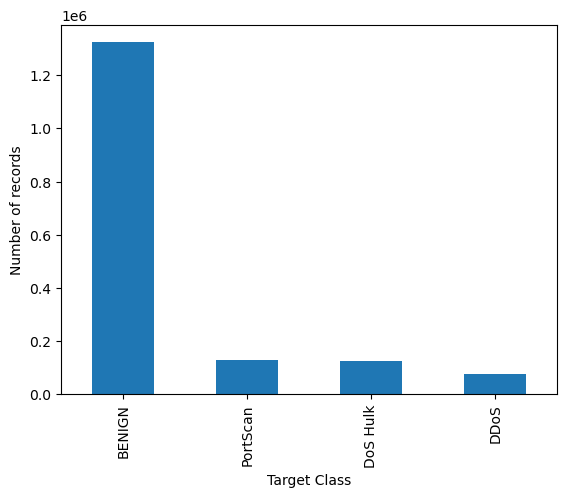

In [ ]:
import matplotlib.pyplot as plt
count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

In [ ]:
from imblearn.under_sampling import NearMiss
n_samples = len(y_train[y_train=="PortScan"])
nm1 = NearMiss(sampling_strategy={"BENIGN":50000},version=1)
X_under, y_under = nm1.fit_resample(X_train, y_train)

In [ ]:
y_under.value_counts()

PortScan    127122
DoS Hulk    126542
DDoS         75993
BENIGN       50000
Name: Label, dtype: int64